In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
from scipy.optimize import curve_fit

In [2]:
datadir = 'C:/Users/khana/Documents/Masters/Semester 2/Earth and System Modelling/PLASIM/PLASIM Data/'
m100 = xr.open_dataset(datadir + 'm100_monthly.nc')
onepct = xr.open_dataset(datadir + 'onepct_monthly.nc')
double = xr.open_dataset(datadir + 'doubleCO2_monthly.nc')

In [3]:
#taking mean over latitude and longitude so we can plot time
GMST_m100 = m100.ts.mean('lat').mean('lon')
GMST_onepct = onepct.ts.mean('lat').mean('lon')
GMST_double = double.ts.mean('lat').mean('lon')

In [4]:
#creating a time array to help with plotting
time_m100 = np.arange(0,30,1)
time_onepct = np.arange(0,125,1)
time_double = np.arange(0,110,1)

In [5]:
#to store the new yearly mean surface temperature
GMST_m100_mm = np.zeros(len(time_m100))
GMST_onepct_mm = np.zeros(len(time_onepct))
GMST_double_mm = np.zeros(len(time_double))

#loop that calculates the yearly mean temp for each year in the given dataset
for i in range(len(time_m100)):
    GMST_m100_mm[i] = np.sum(GMST_m100[12*i:12*(i+1)])/12

for i in range(len(time_onepct)):
    GMST_onepct_mm[i] = np.sum(GMST_onepct[12*i:12*(i+1)])/12

for i in range(len(time_double)):
    GMST_double_mm[i] = np.sum(GMST_double[12*i:12*(i+1)])/12

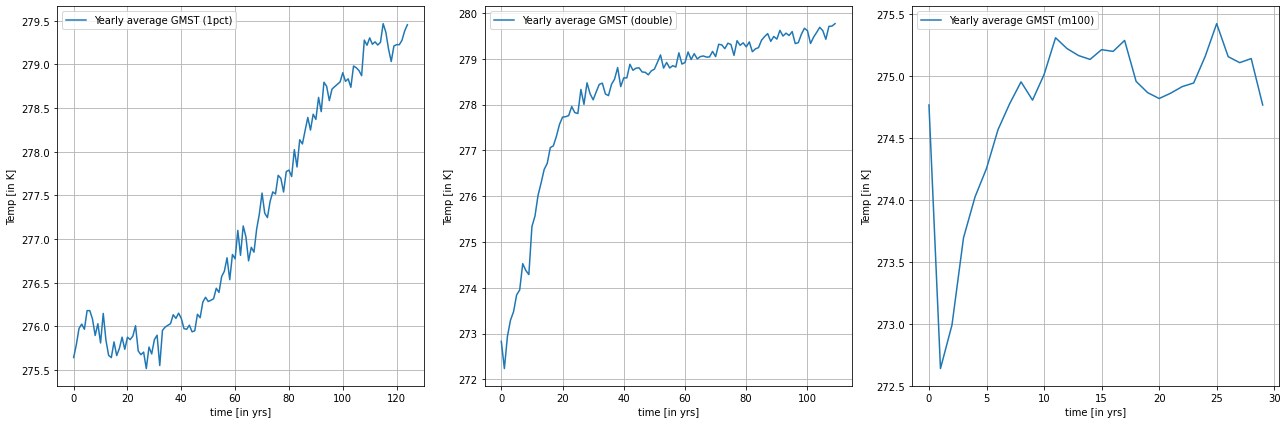

In [6]:
#plotting the yearly mean over time
fig = plt.figure(figsize = (18,6))
ax1,ax2,ax3 = fig.subplots(1,3)

ax1.plot(time_onepct,GMST_onepct_mm, label='Yearly average GMST (1pct)')
ax1.set_xlabel('time [in yrs]')
ax1.set_ylabel('Temp [in K]')
ax1.legend()
ax1.grid()

ax2.plot(time_double,GMST_double_mm, label='Yearly average GMST (double)')
ax2.set_xlabel('time [in yrs]')
ax2.set_ylabel('Temp [in K]')
ax2.legend()
ax2.grid()

ax3.plot(time_m100,GMST_m100_mm, label='Yearly average GMST (m100)')
ax3.set_xlabel('time [in yrs]')
ax3.set_ylabel('Temp [in K]')
ax3.legend()
ax3.grid()

plt.tight_layout()

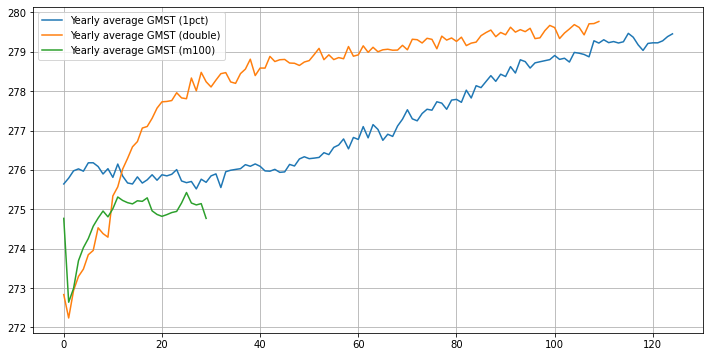

In [7]:
#all the plots together
plt.figure(figsize=(12,6))
plt.plot(time_onepct,GMST_onepct_mm, label='Yearly average GMST (1pct)')
plt.plot(time_double,GMST_double_mm, label='Yearly average GMST (double)')
plt.plot(time_m100,GMST_m100_mm, label='Yearly average GMST (m100)')
plt.legend()
plt.grid()
plt.show()

#### Now, lets create the emulator!

The formula for the radiative forcing is as follows: $$ T(t) = \sum_{\tau=0}^t R(t-\tau)F(\tau) $$ so, first we need to calculate the $R(x)$ and $F(x)$

In [8]:
def m100_carbon(tau):
    t = 30
    CO2 = [285 for i in range(t)]
    CO2[1] = CO2[0] - 100
    return CO2[tau]

def m100_F(tau):
    return (3.74/np.log(2))*np.log(m100_carbon(tau)/m100_carbon(0))

def onepct_carbon(tau):
    t = 125
    CO2 = [285 for i in range(t)]
    for i in range(t-1):
        CO2[i + 1] = CO2[i] + 0.01 * CO2[i]
    return CO2[tau]

def onepct_F(tau):
    return (3.74/np.log(2))*np.log(onepct_carbon(tau)/onepct_carbon(0))

def double_carbon(tau):
    t = 110
    CO2 = [285 for i in range(t)]
    CO2[1] = CO2[0]*2
    return CO2[tau]

def double_F(tau):
    return (3.74/np.log(2))*np.log(double_carbon(tau)/double_carbon(0))

In [20]:
def m100_temp(t,q1,d1,q2,d2):
    
    t = 30
    temp = []
    dx = np.zeros(shape=(t, t))
    R = np.zeros(shape=(t, t))
    
    for i in range(t):
        for j in range(t):
            if i >= j:
                dx[i][j] = i - j
                R[i][j] = q1*np.exp(-dx[i][j]/d1) + q2*np.exp(-dx[i][j]/d2)

        temp.append(np.sum(R[i]*m100_F(i)))
    
    return temp + GMST_m100_mm[0]

In [21]:
fit_values, _ = curve_fit(m100_temp,time_m100,GMST_m100_mm)

In [22]:
fit_values

array([-0.33249721,  1.        ,  1.        ,  1.        ])

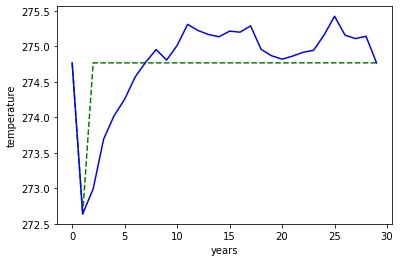

In [23]:
plt.plot(time_m100, m100_temp(time_m100, *fit_values), 'g--')
plt.plot(time_m100, GMST_m100_mm, 'b',)
plt.xlabel('years')
plt.ylabel('temperature')

plt.show()

In [ ]:
t = 30
q1 = 0.33
d1 = 239
q2 = 0.41
d2 = 4.1

temp = []
dx = np.zeros(shape=(t, t))
R = np.zeros(shape=(t, t))

for i in range(t):
    for j in range(t):
        if i >= j:
            dx[i][j] = i - j
            R[i][j] = q1*np.exp(-dx[i][j]/d1) + q2*np.exp(-dx[i][j]/d2)

    temp.append(np.sum(R[i]*m100_F(i)))

In [ ]:
temp + GMST_m100_mm

In [ ]:
for i in range(5):
    print(m100_carbon(i))

In [ ]:
for i in range(5):
    print(m100_F(i))

In [ ]:
def carbon_conc(tau, regime):
    
#    if regime == 'm100':
    time = 30
    CO2 = [285 for i in range(time)]
    CO2[1] = 185
        
#     if regime == 'onepct':
#         time = 125
#         CO2 = [285 for i in range(time)]
#         for i in range(time-1):
#             CO2[i + 1] = CO2[i] + 0.01 * CO2[i]
            
#     if regime == 'double':
#         time = 110
#         CO2 = [285 for i in range(time)]
#         CO2[1] = CO2[0]*2
        
    return CO2[tau]

In [ ]:
def F(tau, regime):
    return (3.74/np.log(2))*np.log(carbon_conc(tau, regime)/carbon_conc(0,regime))

In [ ]:
def temp_wrt_preind(regime,q1,d1,q2,d2):
    """
    time = length of time simulation will run for (monthly data available for 30 yrs)
    q1, q2 = radiative forcing constants (default = 0.33 K/m^2, 0.41 K/m^2)
    d1, d2 = some kind of time in years (default = 239 yrs, 4.1 yrs)
    
    """
    temp = []
    
#    if regime == 'm100':
    time = 30
    dx = np.zeros(shape=(time, time))
    R = np.zeros(shape=(time, time))
        
#     if regime == 'onepct':
#         time = 125
#         dx = np.zeros(shape=(time, time))
#         R = np.zeros(shape=(time, time))
            
#     if regime == 'double':
#         time = 110
#         dx = np.zeros(shape=(time, time))
#         R = np.zeros(shape=(time, time))
    
    for i in range(time):
        for j in range(time):
            if i >= j:
                dx[i][j] = i - j
                R[i][j] = q1*np.exp(-dx[i][j]/d1) + q2*np.exp(-dx[i][j]/d2)
                
        temp.append(np.sum(R[i]*F(time,regime)))
    
    return temp

In [ ]:

def T(time,q1,d1,q2,d2):
    if time == 30:
        return temp_wrt_preind(time,q1,d1,q2,d2)
    if time == 125:
        return temp_wrt_preind('onepct',q1,d1,q2,d2)
    if time == 110:
        return temp_wrt_preind('double',q1,d1,q2,d2)

In [ ]:
fit_values

In [ ]:
plt.plot(years, temp(years, *fit_values), 'g--', label='fit: q1=%5.3f, d1=%5.3f, q2=%5.3f, d2=%5.3f' % tuple(popt1))
plt.plot(years, yearlyGMST, 'b-', label='simulated GMST')
plt.xlabel('years')
plt.ylabel('temperature')
plt.legend()
plt.show()